In [12]:
import requests
from bs4 import BeautifulSoup
import hashlib
import time
import pandas as pd
pd.set_option('display.max_colwidth', None)
import re
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

In [13]:
BRAND = "toyota"
MODEL = "yaris"
LOCATION = "gdansk"
RADIUS = "100"
THRESHOLD = 0.5
PRICE_TOP_LIMIT = 30000

polish_months = {
    "stycznia": "01", "lutego": "02", "marca": "03", "kwietnia": "04",
    "maja": "05", "czerwca": "06", "lipca": "07", "sierpnia": "08",
    "września": "09", "października": "10", "listopada": "11", "grudnia": "12"
}

In [14]:
class Offer:
    def __init__(self, title, price, year_mileage, url=None, date=None):
        self.title = title
        self.price = self.parse_price(price)
        self.year, self.mileage = self.parse_year_mileage(year_mileage)
        self.url = url
        self.date = self.parse_date(date) 

    def parse_price(self, price_str):
        price_digits = re.sub(r'[^\d]', '', price_str)
        return int(price_digits) if price_digits else None

    def parse_year_mileage(self, text):
        try:
            parts = text.split('-')
            year = int(parts[0].strip()) if parts else None
            mileage_match = re.search(r'(\d[\d\s]*)\s*km', text)
            mileage = int(mileage_match.group(1).replace(' ', '')) if mileage_match else None
            return year, mileage
        except Exception:
            return None, None
        
    def parse_date(self, raw_date_text):
        """
        Parses OLX date strings like:
        - 'Wrocław, Fabryczna - Dzisiaj o 11:04'
        - 'Ostróda - Odświeżono dnia 07 lipca 2025'
        """
        try:
            raw_date_text = raw_date_text.lower()

            if "dzisiaj" in raw_date_text:
                return datetime.today().date()
            if "wczoraj" in raw_date_text:
                return (datetime.today() - timedelta(days=1)).date()

            # Extract e.g. "07 lipca 2025"
            match = re.search(r'(\d{1,2}) (\w+) (\d{4})', raw_date_text)
            if not match:
                print(f"ERROR: COULD NOT MATCH '{raw_date_text}'")
                return None

            day, month_name, year = match.groups()
            month = polish_months.get(month_name.lower())
            if not month:
                print(f"ERROR: Unknown month '{month_name}'")
                return None

            date_str = f"{year}-{month}-{int(day):02d}"
            return datetime.strptime(date_str, "%Y-%m-%d").date()

        except Exception as e:
            print("ERROR parsing date:", e)
            return None

    def to_dict(self):
        return {
            'title': self.title,
            'price': self.price,
            'year': self.year,
            'mileage': self.mileage,
            'url': self.url,
            'date': str(self.date) if self.date else None
        }

    def __str__(self):
        return f"{self.title} | {self.price} PLN | {self.year} | {self.mileage} km"

In [15]:

def scrape_offers(base_url, max_pages=None):
    headers = {'User-Agent': 'Mozilla/5.0'}
    page = 1
    seen_hashes = set()       # For detecting duplicate pages (optional)
    seen_urls = set()         # For detecting duplicate offers across pages
    all_offers = list()

    print(f"🚗 Starting scrape: {base_url}")
    while True:
        url = f"{base_url}&page={page}"
        print(f"\n🔎 Scraping page {page}: {url}")
    
        response = requests.get(url, headers=headers)
        if response.status_code != 200:
            print(f"⚠️ Failed to fetch page {page}, status code: {response.status_code}")
            break

        soup = BeautifulSoup(response.text, 'html.parser')
        offers = soup.find_all('div', class_='css-1apmciz')

        if not offers:
            print("⚠️ No listings found. Ending scrape.")
            break

        new_offers_this_page = 0
        for offer in offers:
            try:
                title_tag = offer.find('h4', class_='css-1g61gc2')
                title = title_tag.text.strip() if title_tag else "No title"

                price_tag = offer.find('p', {'data-testid': 'ad-price'})
                price = price_tag.text.strip() if price_tag else "No price"

                ym_tag = offer.find('div', class_='css-1kfqt7f')
                year_mileage = ym_tag.get_text(strip=True) if ym_tag else "No year/mileage"

                url_tag = offer.find('a', href=True)
                raw_href = url_tag['href'] if url_tag else None
                offer_url = raw_href if raw_href.startswith("http") else "https://www.olx.pl" + raw_href
                
                date_tag = offer.find('p', {'data-testid': 'location-date'})
                date_text = date_tag.text.strip() if date_tag else "No date"

                # Skip if we've already seen this offer URL
                if offer_url in seen_urls:
                    print(f"🔁 Duplicate offer skipped: {offer_url}")
                    continue
                seen_urls.add(offer_url)
                new_offers_this_page += 1
                    
                offer_obj = Offer(title, price, year_mileage, url=offer_url, date=date_text)
                all_offers.append(offer_obj)

                print(f"✅ {offer_obj}")

            except Exception as e:
                print("❌ Error parsing offer:", e)

        if new_offers_this_page == 0:
            print("🛑 All offers on this page were duplicates. Ending scrape.")
            break
        page += 1
        if max_pages and page > max_pages:
            print(f"⏹ Reached max_pages limit: {max_pages}")
            break

        time.sleep(1)  # Be polite to OLX servers

    print(f"\n✅ Done scraping {len(all_offers)} listings from {base_url}\n")
    return all_offers


In [16]:
def build_olx_url(brand, model, location=None, radius=None):
    base = f"https://www.olx.pl/motoryzacja/samochody/{brand}/"
    # Specify location of the offers:
    if location:
        base += f"{location}/"
    base += f"?search%5Bfilter_enum_model%5D%5B0%5D={model}"
    if radius and location:
        base += f"&search%5Bdist%5D={radius}"
    # Look for not damaged cars:
    base += "&search%5Bfilter_enum_condition%5D%5B0%5D=notdamaged&search%5Bfilter_enum_petrol%5D%5B0%5D=petrol"
    return base

In [17]:
# URLs for both scrapes
url_all_cars = build_olx_url(BRAND, MODEL)
url_localized_cars = build_olx_url(BRAND, MODEL, LOCATION, RADIUS)

# Scrape ALL cars first
all_cars_offers = scrape_offers(url_all_cars)

# Scrape only cars near Gdansk
localized_offers = scrape_offers(url_localized_cars)

# Save results
pd.DataFrame([o.to_dict() for o in all_cars_offers]).to_csv(f"all_{BRAND}_{MODEL}_olx.csv", index=False, encoding='utf-8-sig')
print(f"📁 All cars data saved to all_{BRAND}_{MODEL}_olx.csv")

pd.DataFrame([o.to_dict() for o in localized_offers]).to_csv(f"{LOCATION}_{BRAND}_{MODEL}_olx.csv", index=False, encoding='utf-8-sig')
print(f"📁 {LOCATION} cars data saved to {LOCATION}_{BRAND}_{MODEL}_olx.csv")

🚗 Starting scrape: https://www.olx.pl/motoryzacja/samochody/toyota/?search%5Bfilter_enum_model%5D%5B0%5D=yaris&search%5Bfilter_enum_condition%5D%5B0%5D=notdamaged&search%5Bfilter_enum_petrol%5D%5B0%5D=petrol

🔎 Scraping page 1: https://www.olx.pl/motoryzacja/samochody/toyota/?search%5Bfilter_enum_model%5D%5B0%5D=yaris&search%5Bfilter_enum_condition%5D%5B0%5D=notdamaged&search%5Bfilter_enum_petrol%5D%5B0%5D=petrol&page=1
✅ Toyota Yaris Idealna na pierwszy pojazd, od 15 lat w rekękach jednej właścicielki! | 9999 PLN | 2007 | 220100 km
✅ Toyota Yaris 1.3 benzyna, 2008 r. | 11750 PLN | 2008 | 252166 km
✅ TOYOTA Yaris 2004 | 3800 PLN | 2004 | 221000 km
✅ Toyota Yaris Premiere Edition 1.5 benzyna 125KM I właścicielka salonPL | 99000 PLN | 2021 | 26000 km
✅ Toyota Yaris Salon Polska | 15000 PLN | 2007 | 148000 km
✅ Toyota yaris 1.0 benzyna 2006 rok | 5900 PLN | 2006 | 277000 km
✅ Toyota yaris , 5 drzwi, klimatyzacja polski salon | 5900 PLN | 2006 | 210000 km
✅ Toyota Yaris 1.0 Polecam | 10600

In [18]:
# Filter out offers
df = pd.read_csv(f"all_{BRAND}_{MODEL}_olx.csv")

# Drop rows without price/year
df = df.dropna(subset=["price", "year"])

# Fix mileage likely expressed without thousands
df.loc[(df["mileage"] > 1) & (df["mileage"] < 1000), "mileage"] = (df["mileage"] * 1000)
df.loc[(df["mileage"] > 1000000), "mileage"] = (df["mileage"] / 10)
# Remove unreasonable values
df = df[(df["mileage"] >= 2) & (df["price"] >= 1000) & (df["price"] <= 30000) & (df["year"] <= 2015)]

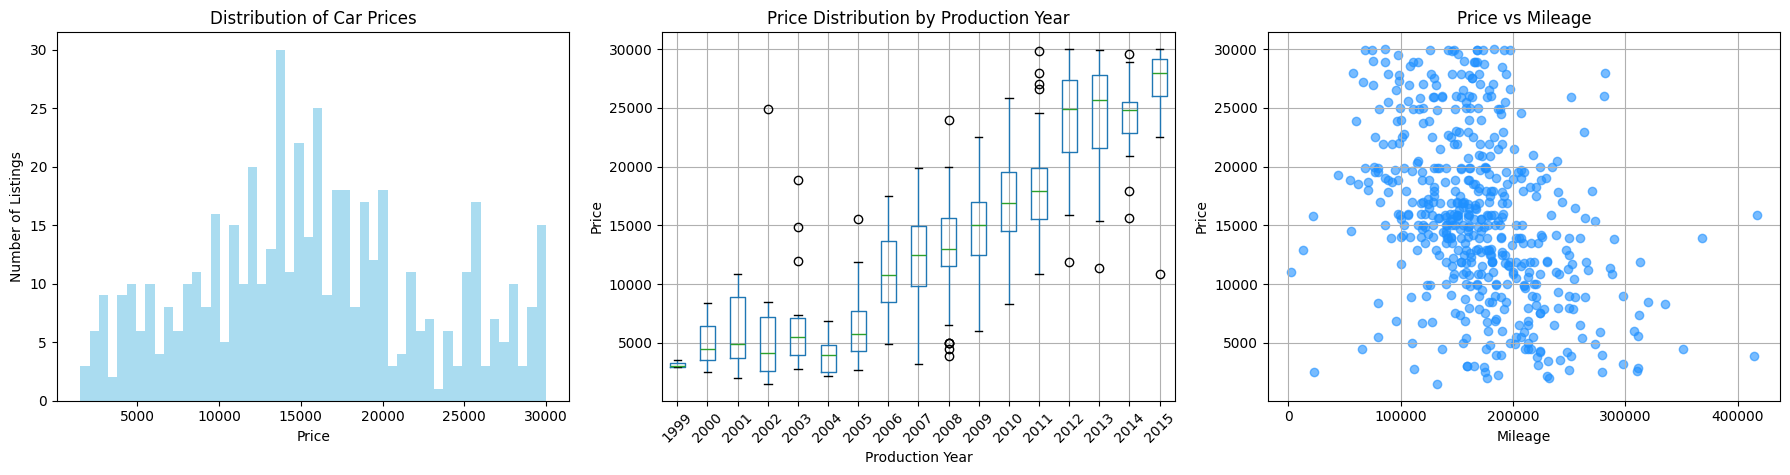

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

# 1) Histogram of Price
axs[0].hist(df['price'], bins=50, color='skyblue', alpha=0.7)
axs[0].set_xlabel('Price')
axs[0].set_ylabel('Number of Listings')
axs[0].set_title('Distribution of Car Prices')

# 2) Boxplot of Price by Year
df.boxplot(column='price', by='year', grid=True, ax=axs[1])
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45)
axs[1].set_title('Price Distribution by Production Year')
axs[1].set_xlabel('Production Year')
axs[1].set_ylabel('Price')
# Remove the automatic suptitle from boxplot
plt.suptitle('')

# 3) Scatter plot Price vs Mileage
axs[2].scatter(df['mileage'], df['price'], alpha=0.6, color='dodgerblue')
axs[2].grid(True)
axs[2].set_xlabel('Mileage')
axs[2].set_ylabel('Price')
axs[2].set_title('Price vs Mileage')

plt.tight_layout()
plt.show()


In [20]:
grouped = df.groupby('year')['price']
q1_prices = grouped.quantile(0.25)
q3_prices = grouped.quantile(0.75)
iqr_prices = q3_prices - q1_prices
threshold = q1_prices - 1.5 * iqr_prices

df["iqr_threshold"] = df["year"].map(threshold)
df['q1_price'] = df['year'].map(q1_prices)
df['q3_price'] = df['year'].map(q3_prices)
df['iqr_price'] = df['year'].map(iqr_prices)

# Keep offers cheaper than (mean - 1×std)
df['cheap'] = df['price'] < (df['q1_price'] - THRESHOLD * df['iqr_price'])

# Optional: calculate discount % for clarity
df["discount"] = ((df["iqr_threshold"] - df["price"]) / df["price"] * 100).round(1)

# Keep only the cheap ones
df = df[df["cheap"]]

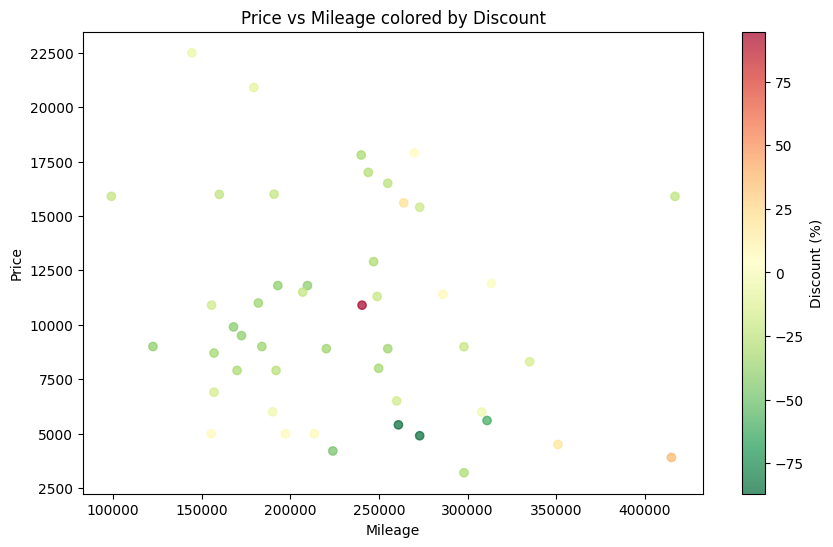

In [21]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['mileage'], df['price'], c=df['discount'], cmap='RdYlGn_r', alpha=0.7)
plt.colorbar(scatter, label='Discount (%)')
plt.xlabel('Mileage')
plt.ylabel('Price')
plt.title('Price vs Mileage colored by Discount')
plt.show()

In [22]:
html_df = df.copy()
localized_df = pd.read_csv(f"{LOCATION}_{BRAND}_{MODEL}_olx.csv", encoding="utf-8-sig")
localized_urls = set(localized_df['url'].str.lower().str.strip())

def make_clickable(url):
    url_norm = url.lower().strip()
    if url_norm in localized_urls:
        # Highlight: e.g. green, bold, underline
        return f'<a href="{url}" target="_blank" style="color:green; font-weight:bold; text-decoration:underline;">Nearby</a>'
    else:
        return f'<a href="{url}" target="_blank">Link</a>'

html_df['url'] = html_df['url'].apply(make_clickable)

# Select relevant columns
columns = ['title', 'price', 'year', 'mileage', 'discount', 'date', 'url']
html_table = html_df[columns].to_html(
    escape=False,
    index=False,
    justify='left',
    border=0,
    table_id="dealTable"
)

# HTML with sortable table support
html_output = f"""
<html>
<head>
    <title>Good Car Deals</title>
    <style>
        body {{ font-family: Arial, sans-serif; margin: 2em; }}
        table {{ border-collapse: collapse; width: 100%; }}
        th, td {{ padding: 8px 12px; border: 1px solid #ccc; }}
        th {{ background-color: #f4f4f4; cursor: pointer; }}
        tr:nth-child(even) {{ background-color: #fafafa; }}
    </style>
</head>
<body>
    <h2>🚗 Good Car Deals (>1 sigma lower than the mean)</h2>

    {html_table}

    <!-- DataTables CSS -->
    <link rel="stylesheet" href="https://cdn.datatables.net/1.13.6/css/jquery.dataTables.min.css">

    <!-- jQuery and DataTables JS -->
    <script src="https://code.jquery.com/jquery-3.7.0.min.js"></script>
    <script src="https://cdn.datatables.net/1.13.6/js/jquery.dataTables.min.js"></script>

    <script>
    $(document).ready(function(){{
        $('#dealTable').DataTable({{
            paging: false,
            info: false
        }});
    }});
    </script>
</body>
</html>
"""

# Save to file
with open("good_deals.html", "w", encoding="utf-8") as f:
    f.write(html_output)

print("✅ Exported to good_deals.html with sortable columns!")

    
import webbrowser
webbrowser.open("good_deals.html")

✅ Exported to good_deals.html with sortable columns!


True